In [1]:
!pip install torch faiss-cpu
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torch_geometric
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, HeteroConv
from torch_geometric.loader import NeighborLoader
import numpy as np
import faiss
import os
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import pickle

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
block_size = 64          # Context window size
subset_size = 10000     # Size of the subset to use from Enwik8
k = 32                   # Number of nearest neighbors
embed_dim = 64           # Embedding dimension
num_heads = 4            # Number of attention heads
num_layers = 4           # Number of Transformer layers
num_gnn_layers = 3       # Number of GNN layers
hidden_channels = 128    # Hidden channels in GNN
batch_size = 128         # Batch size for DataLoader
num_epochs = 20          # Number of training epochs
num_workers = 4          # Number of workers for DataLoader
accumulation_steps = 4   # Gradient accumulation steps
chunk_size = 50000       # Chunk size for processing large data

In [5]:
# Base Transformer Model Metrics
train_losses = []
val_losses = []
train_bpcs = []
val_bpcs = []
train_accuracies = [] 
val_accuracies = []

# Heterogeneous GNN Model Metrics
gnn_train_losses = []
gnn_val_losses = []
gnn_train_bpcs = []
gnn_val_bpcs = []
gnn_train_accuracies = []
gnn_val_accuracies = []

In [6]:
if not os.path.exists('enwik8.zip'):
    os.system('wget -c http://mattmahoney.net/dc/enwik8.zip')
    os.system('unzip -o enwik8.zip')

with open('enwik8', 'r') as f:
    data = f.read(subset_size)

def build_vocab(data):
    counter = Counter(data)
    chars = sorted(counter.keys())
    vocab = {ch: i for i, ch in enumerate(chars)}
    return vocab

vocab = build_vocab(data)
vocab_size = len(vocab)
print(f'Vocabulary size: {vocab_size}')

def encode_data(data, vocab):
    return [vocab[ch] for ch in data]

data_ids = encode_data(data, vocab)

num_test = len(data_ids) // 10
train_ids = data_ids[:-2 * num_test]
valid_ids = data_ids[-2 * num_test:-num_test]
test_ids = data_ids[-num_test:]

class TextDataset(Dataset):
    def __init__(self, data_ids, block_size):
        self.data_ids = data_ids
        self.block_size = block_size

    def __len__(self):
        return len(self.data_ids) - self.block_size

    def __getitem__(self, idx):
        x = torch.tensor(self.data_ids[idx:idx + self.block_size], dtype=torch.long)
        y = torch.tensor(self.data_ids[idx + 1:idx + 1 + self.block_size], dtype=torch.long)
        return x, y

train_dataset = TextDataset(train_ids, block_size)
valid_dataset = TextDataset(valid_ids, block_size)
test_dataset = TextDataset(test_ids, block_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size,
                          num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         num_workers=num_workers, pin_memory=True)

print("Dataset loading and processing completed.")

Vocabulary size: 86
Dataset loading and processing completed.


In [7]:
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, block_size):
        super(TransformerLM, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(block_size, embed_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        seq_length = x.size(1)
        positions = torch.arange(0, seq_length, device=x.device).unsqueeze(0).expand(x.size(0), seq_length)
        x = self.token_embedding(x) + self.position_embedding(positions)
        x = x.permute(1, 0, 2)  # (seq_length, batch_size, embed_dim)
        output = self.transformer(x)
        output = output.permute(1, 0, 2)  # (batch_size, seq_length, embed_dim)
        logits = self.fc_out(output)
        return logits, output  # Return logits and hidden states

base_model = TransformerLM(vocab_size, embed_dim, num_heads, num_layers, block_size).to(device)
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()

In [8]:
# Training the Base Transformer Model

for epoch in range(num_epochs):
    base_model.train()
    total_loss = 0
    correct_predictions = 0  # For accuracy (optional)
    total_tokens = 0         # For accuracy (optional)
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for x, y in progress_bar:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad()
        with autocast():
            logits, _ = base_model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        
        # Optional: Compute accuracy
        predictions = logits.argmax(dim=-1)
        correct_predictions += (predictions.view(-1) == y.view(-1)).sum().item()
        total_tokens += y.numel()
        
        progress_bar.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Calculate BPC
    train_bpc = avg_loss / math.log(2)
    train_bpcs.append(train_bpc)
    
    # Optional: Calculate Accuracy
    train_accuracy = correct_predictions / total_tokens
    train_accuracies.append(train_accuracy)
    
    print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Training BPC: {train_bpc:.4f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Validation Phase
    base_model.eval()
    val_loss = 0
    correct_val = 0  # For accuracy (optional)
    total_val = 0     # For accuracy (optional)
    with torch.no_grad():
        for x_val, y_val in valid_loader:
            x_val = x_val.to(device, non_blocking=True)
            y_val = y_val.to(device, non_blocking=True)
            with autocast():
                logits_val, _ = base_model(x_val)
                loss_val = criterion(logits_val.view(-1, vocab_size), y_val.view(-1))
            val_loss += loss_val.item()
            
            # Optional: Compute accuracy
            predictions_val = logits_val.argmax(dim=-1)
            correct_val += (predictions_val.view(-1) == y_val.view(-1)).sum().item()
            total_val += y_val.numel()
    
    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    
    # Calculate BPC for validation
    val_bpc = avg_val_loss / math.log(2)
    val_bpcs.append(val_bpc)
    
    # Optional: Calculate Validation Accuracy
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}, Validation BPC: {val_bpc:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Save the Base Model
torch.save(base_model.state_dict(), 'base_model.pth')
print("Base language model trained and saved successfully.")

Epoch 1/20: 100%|██████████| 62/62 [00:01<00:00, 42.98it/s, loss=3.46]

Epoch 1, Training Loss: 3.7309, Training BPC: 5.3825, Training Accuracy: 0.1634


Epoch 1, Validation Loss: 3.6439, Validation BPC: 5.2570, Validation Accuracy: 0.1389


Epoch 2/20: 100%|██████████| 62/62 [00:00<00:00, 80.49it/s, loss=3.04]

Epoch 2, Training Loss: 3.1952, Training BPC: 4.6097, Training Accuracy: 0.2641


Epoch 2, Validation Loss: 3.3124, Validation BPC: 4.7788, Validation Accuracy: 0.1779


Epoch 3/20: 100%|██████████| 62/62 [00:00<00:00, 85.24it/s, loss=2.76]


Epoch 3, Training Loss: 2.8706, Training BPC: 4.1413, Training Accuracy: 0.3171
Epoch 3, Validation Loss: 3.0802, Validation BPC: 4.4439, Validation Accuracy: 0.2123


Epoch 4/20: 100%|██████████| 62/62 [00:00<00:00, 76.00it/s, loss=2.54]

Epoch 4, Training Loss: 2.6505, Training BPC: 3.8239, Training Accuracy: 0.3559


Epoch 4, Validation Loss: 2.9307, Validation BPC: 4.2281, Validation Accuracy: 0.2299


Epoch 5/20: 100%|██████████| 62/62 [00:00<00:00, 80.00it/s, loss=2.4] 

Epoch 5, Training Loss: 2.4915, Training BPC: 3.5944, Training Accuracy: 0.3799


Epoch 5, Validation Loss: 2.8352, Validation BPC: 4.0904, Validation Accuracy: 0.2429


Epoch 6/20: 100%|██████████| 62/62 [00:00<00:00, 73.94it/s, loss=2.28]

Epoch 6, Training Loss: 2.3719, Training BPC: 3.4219, Training Accuracy: 0.3951


Epoch 6, Validation Loss: 2.7720, Validation BPC: 3.9991, Validation Accuracy: 0.2516


Epoch 7/20: 100%|██████████| 62/62 [00:00<00:00, 71.18it/s, loss=2.24]

Epoch 7, Training Loss: 2.2759, Training BPC: 3.2834, Training Accuracy: 0.4074


Epoch 7, Validation Loss: 2.7205, Validation BPC: 3.9248, Validation Accuracy: 0.2624


Epoch 8/20: 100%|██████████| 62/62 [00:00<00:00, 71.99it/s, loss=2.17]

Epoch 8, Training Loss: 2.1956, Training BPC: 3.1675, Training Accuracy: 0.4185


Epoch 8, Validation Loss: 2.6824, Validation BPC: 3.8698, Validation Accuracy: 0.2702


Epoch 9/20: 100%|██████████| 62/62 [00:00<00:00, 79.80it/s, loss=2.12]

Epoch 9, Training Loss: 2.1272, Training BPC: 3.0689, Training Accuracy: 0.4284


Epoch 9, Validation Loss: 2.6496, Validation BPC: 3.8226, Validation Accuracy: 0.2743


Epoch 10/20: 100%|██████████| 62/62 [00:00<00:00, 75.41it/s, loss=1.99]

Epoch 10, Training Loss: 2.0663, Training BPC: 2.9811, Training Accuracy: 0.4355


Epoch 10, Validation Loss: 2.6235, Validation BPC: 3.7849, Validation Accuracy: 0.2784


Epoch 11/20: 100%|██████████| 62/62 [00:00<00:00, 75.26it/s, loss=1.95]

Epoch 11, Training Loss: 2.0100, Training BPC: 2.8998, Training Accuracy: 0.4444


Epoch 11, Validation Loss: 2.5939, Validation BPC: 3.7423, Validation Accuracy: 0.2877


Epoch 12/20: 100%|██████████| 62/62 [00:00<00:00, 77.45it/s, loss=1.98]

Epoch 12, Training Loss: 1.9582, Training BPC: 2.8251, Training Accuracy: 0.4515


Epoch 12, Validation Loss: 2.5723, Validation BPC: 3.7111, Validation Accuracy: 0.2908


Epoch 13/20: 100%|██████████| 62/62 [00:00<00:00, 75.17it/s, loss=1.91]

Epoch 13, Training Loss: 1.9088, Training BPC: 2.7537, Training Accuracy: 0.4590


Epoch 13, Validation Loss: 2.5501, Validation BPC: 3.6790, Validation Accuracy: 0.2947


Epoch 14/20: 100%|██████████| 62/62 [00:00<00:00, 74.45it/s, loss=1.82]

Epoch 14, Training Loss: 1.8586, Training BPC: 2.6814, Training Accuracy: 0.4687


Epoch 14, Validation Loss: 2.5096, Validation BPC: 3.6206, Validation Accuracy: 0.3087


Epoch 15/20: 100%|██████████| 62/62 [00:00<00:00, 74.57it/s, loss=1.77]


Epoch 15, Training Loss: 1.8023, Training BPC: 2.6002, Training Accuracy: 0.4813
Epoch 15, Validation Loss: 2.4579, Validation BPC: 3.5460, Validation Accuracy: 0.3279


Epoch 16/20: 100%|██████████| 62/62 [00:00<00:00, 77.36it/s, loss=1.71]

Epoch 16, Training Loss: 1.7302, Training BPC: 2.4961, Training Accuracy: 0.5029


Epoch 16, Validation Loss: 2.3587, Validation BPC: 3.4029, Validation Accuracy: 0.3618


Epoch 17/20: 100%|██████████| 62/62 [00:00<00:00, 77.05it/s, loss=1.57]

Epoch 17, Training Loss: 1.6267, Training BPC: 2.3468, Training Accuracy: 0.5363


Epoch 17, Validation Loss: 2.1876, Validation BPC: 3.1560, Validation Accuracy: 0.4170


Epoch 18/20: 100%|██████████| 62/62 [00:00<00:00, 75.36it/s, loss=1.46]

Epoch 18, Training Loss: 1.4826, Training BPC: 2.1389, Training Accuracy: 0.5834


Epoch 18, Validation Loss: 1.9271, Validation BPC: 2.7802, Validation Accuracy: 0.4933


Epoch 19/20: 100%|██████████| 62/62 [00:00<00:00, 75.64it/s, loss=1.19]

Epoch 19, Training Loss: 1.3096, Training BPC: 1.8894, Training Accuracy: 0.6388


Epoch 19, Validation Loss: 1.6361, Validation BPC: 2.3604, Validation Accuracy: 0.5758


Epoch 20/20: 100%|██████████| 62/62 [00:00<00:00, 75.59it/s, loss=1.09]

Epoch 20, Training Loss: 1.1244, Training BPC: 1.6222, Training Accuracy: 0.6966


Epoch 20, Validation Loss: 1.3366, Validation BPC: 1.9283, Validation Accuracy: 0.6583
Base language model trained and saved successfully.


In [9]:
def extract_representations(model, data_loader, reps_filename, targets_filename, embed_dim, device):
    model.eval()
    total_samples = len(data_loader.dataset) * block_size
    reps_shape = (total_samples, embed_dim)
    targets_shape = (total_samples,)

    # Initialize memmap files
    reps_memmap = np.memmap(reps_filename, dtype='float32', mode='w+', shape=reps_shape)
    targets_memmap = np.memmap(targets_filename, dtype='int64', mode='w+', shape=targets_shape)

    index = 0  # Keeps track of the current position in memmap
    with torch.no_grad():
        for x, y in tqdm(data_loader, desc="Extracting representations"):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            _, hidden_states = model(x)
            batch_size_, seq_length, _ = hidden_states.size()

            # Reshape and move to CPU
            reps_batch = hidden_states.reshape(-1, embed_dim).cpu().numpy()
            targets_batch = y.reshape(-1).cpu().numpy()
            batch_sample_size = reps_batch.shape[0]

            # Write to memmap
            reps_memmap[index:index + batch_sample_size] = reps_batch
            targets_memmap[index:index + batch_sample_size] = targets_batch
            index += batch_sample_size

    # Flush memmap to ensure data is written to disk
    reps_memmap.flush()
    targets_memmap.flush()

    # Return the paths to the memmap files
    return reps_filename, targets_filename

# Paths to memmap files
train_reps_file = 'train_reps.memmap'
train_targets_file = 'train_targets.memmap'

# Delete Existing FAISS Index and Memmap Files to Prevent Dimension Mismatch
faiss_index_path = 'faiss_index.faiss'
memmap_files = [train_reps_file, train_targets_file, 'test_reps.memmap', 'test_targets.memmap']

for file in memmap_files:
    if os.path.exists(file):
        os.remove(file)
        print(f"Existing {file} removed.")

if os.path.exists(faiss_index_path):
    os.remove(faiss_index_path)
    print("Existing FAISS index removed to prevent dimension mismatch.")

# Extract and save training representations
train_reps_file, train_targets_file = extract_representations(
    base_model,
    train_loader,
    reps_filename=train_reps_file,
    targets_filename=train_targets_file,
    embed_dim=embed_dim,
    device=device
)

# Load Training Representations
print("Loading training representations from memmap...")
total_train_samples = len(train_dataset) * block_size
train_reps = np.memmap(train_reps_file, dtype='float32', mode='r+', shape=(total_train_samples, embed_dim))
train_targets = np.memmap(train_targets_file, dtype='int64', mode='r+', shape=(total_train_samples,))

# Normalize Representations in Chunks to Save Memory
print("Normalizing training representations...")
for i in tqdm(range(0, train_reps.shape[0], chunk_size), desc="Normalizing training reps"):
    reps_chunk = train_reps[i:i+chunk_size]
    norms = np.linalg.norm(reps_chunk, axis=1, keepdims=True)
    train_reps[i:i+chunk_size] = reps_chunk / (norms + 1e-10)  # Add epsilon to prevent division by zero

# Building FAISS Index Incrementally

# Initialize FAISS index (using Inner Product for cosine similarity assuming normalized vectors)
index = faiss.IndexFlatIP(embed_dim)

batch_size_faiss = 50000  # Adjust based on available RAM
num_vectors = train_reps.shape[0]

for i in tqdm(range(0, num_vectors, batch_size_faiss), desc="Adding to FAISS index"):
    reps_batch = train_reps[i:i+batch_size_faiss]
    index.add(reps_batch)

# Save the FAISS index to disk
faiss.write_index(index, faiss_index_path)
print(f"FAISS index built successfully. Dimension: {index.d}, Number of vectors: {index.ntotal}")

# Retrieving Neighbor Contexts for Test Data
test_reps_file = 'test_reps.memmap'
test_targets_file = 'test_targets.memmap'

# Extract and save test representations
test_reps_file, test_targets_file = extract_representations(
    base_model,
    test_loader,
    reps_filename=test_reps_file,
    targets_filename=test_targets_file,
    embed_dim=embed_dim,
    device=device
)
print("Test representations extracted successfully.")

# Load Test Representations
print("Loading test representations from memmap...")
total_test_samples = len(test_dataset) * block_size
test_reps = np.memmap(test_reps_file, dtype='float32', mode='r+', shape=(total_test_samples, embed_dim))
test_targets = np.memmap(test_targets_file, dtype='int64', mode='r+', shape=(total_test_samples,))

# Normalize Test Representations in Chunks
print("Normalizing test representations...")
for i in tqdm(range(0, test_reps.shape[0], chunk_size), desc="Normalizing test reps"):
    reps_chunk = test_reps[i:i+chunk_size]
    norms = np.linalg.norm(reps_chunk, axis=1, keepdims=True)
    test_reps[i:i+chunk_size] = reps_chunk / (norms + 1e-10)  # Add epsilon to prevent division by zero

print("Test representations normalized successfully.")

# Load FAISS Index
index = faiss.read_index(faiss_index_path)

# Retrieve kNN Indices and Distances in Chunks
print("Retrieving kNN for test representations...")
D_list = []
I_list = []
for i in tqdm(range(0, test_reps.shape[0], chunk_size), desc="kNN Retrieval"):
    reps_batch = test_reps[i:i+chunk_size].astype('float32')  # Ensure dtype is float32
    if reps_batch.shape[1] != index.d:
        print(f"Dimension mismatch: reps_batch has d={reps_batch.shape[1]}, FAISS index has d={index.d}")
        raise AssertionError(f"Dimension mismatch: reps_batch has d={index.d}, FAISS index has d={index.d}")
    D_batch, I_batch = index.search(reps_batch, k)
    D_list.append(D_batch)
    I_list.append(I_batch)
D = np.vstack(D_list)
I = np.vstack(I_list)
print("kNN Retrieval completed successfully.")

# Constructing the Heterogeneous Graph
def build_graph(test_reps, train_reps, I, test_targets, k):
    graph = HeteroData()
    # Nodes
    graph['ao'].x = torch.tensor(test_reps, dtype=torch.float32)
    graph['ao'].y = torch.tensor(test_targets, dtype=torch.long)  # Assign target labels
    neighbor_indices = I.flatten()
    neighbor_reps = train_reps[neighbor_indices]
    graph['an'].x = torch.tensor(neighbor_reps, dtype=torch.float32)

    # Intra-context edges (within 'ao' nodes)
    num_ao_nodes = test_reps.shape[0]
    src_intra = torch.arange(0, num_ao_nodes - 1, dtype=torch.long)
    dst_intra = torch.arange(1, num_ao_nodes, dtype=torch.long)
    graph['ao', 'rintra', 'ao'].edge_index = torch.stack([src_intra, dst_intra], dim=0)

    # Inter-context edges (from 'an' to 'ao' nodes)
    # Each 'an' node corresponds to a neighbor of an 'ao' node
    num_an_nodes = I.shape[0] * I.shape[1]
    src_inter = torch.arange(num_an_nodes, dtype=torch.long)  # 'an' node indices
    dst_inter = torch.repeat_interleave(torch.arange(num_ao_nodes, dtype=torch.long), k)  # 'ao' node indices
    graph['an', 'rinter', 'ao'].edge_index = torch.stack([src_inter, dst_inter], dim=0)

    return graph

graph = build_graph(test_reps, train_reps, I, test_targets, k)
print("Graph constructed successfully.")

Existing train_reps.memmap removed.
Existing train_targets.memmap removed.
Existing test_reps.memmap removed.
Existing test_targets.memmap removed.
Existing FAISS index removed to prevent dimension mismatch.


Extracting representations: 100%|██████████| 62/62 [00:00<00:00, 101.02it/s]


Loading training representations from memmap...
Normalizing training representations...


Adding to FAISS index: 100%|██████████| 11/11 [00:00<00:00, 53.70it/s]


FAISS index built successfully. Dimension: 64, Number of vectors: 507904


Extracting representations: 100%|██████████| 8/8 [00:00<00:00, 21.98it/s]


Test representations extracted successfully.
Loading test representations from memmap...
Normalizing test representations...


Normalizing test reps: 100%|██████████| 2/2 [00:00<00:00, 75.93it/s]


Test representations normalized successfully.
Retrieving kNN for test representations...


kNN Retrieval: 100%|██████████| 2/2 [02:26<00:00, 73.27s/it] 


kNN Retrieval completed successfully.
Graph constructed successfully.


In [10]:
class HeteroGNNModel(nn.Module):
    def __init__(self, hidden_channels, num_layers, vocab_size):
        super(HeteroGNNModel, self).__init__()
        # Define HeteroConv layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('ao', 'rintra', 'ao'): SAGEConv((-1, -1), hidden_channels),
                ('an', 'rinter', 'ao'): SAGEConv((-1, -1), hidden_channels),
                ('an', 'self', 'an'): SAGEConv((-1, -1), hidden_channels),  # Added self-edges for 'an' nodes
            }, aggr='mean')
            self.convs.append(conv)
        # Final linear layer
        self.fc = nn.Linear(hidden_channels, vocab_size)

    def forward(self, data):
        x_dict, edge_index_dict = data.x_dict, data.edge_index_dict

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            # Apply activation
            for key in x_dict:
                x_dict[key] = F.relu(x_dict[key])

            # Retain 'x' for node types without incoming edges
            for node_type in data.node_types:
                if node_type not in x_dict:
                    x_dict[node_type] = data[node_type].x
                    print(f"Retained original features for node type '{node_type}'.")

        # Assume we are predicting for 'ao' nodes
        x_ao = x_dict['ao']
        logits = self.fc(x_ao)
        return logits

# Adding Self-Edges for 'an' Nodes to Prevent NoneType Errors
num_an_nodes = graph['an'].x.size(0)
src_self = torch.arange(num_an_nodes, dtype=torch.long)
dst_self = src_self.clone()
graph['an', 'self', 'an'].edge_index = torch.stack([src_self, dst_self], dim=0)
print(f"Added {num_an_nodes} self-edges for 'an' nodes.")

# Initialize the Heterogeneous GNN Model, Optimizer, and Loss Function
gnn_model = HeteroGNNModel(hidden_channels, num_gnn_layers, vocab_size).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.0005)
criterion_gnn = nn.CrossEntropyLoss()
scaler_gnn = GradScaler()

Added 1916928 self-edges for 'an' nodes.


In [11]:
# Defining NeighborLoaders for GNN

train_loader_gnn = NeighborLoader(
    graph,
    num_neighbors=[10, 10],          # Number of neighbors to sample at each GNN layer
    batch_size=1024,                  # Number of target nodes per batch
    shuffle=True,
    num_workers=num_workers,
    input_nodes='ao',                 # Specify that 'ao' nodes are the target nodes
)

# Validation Loader for GNN
valid_loader_gnn = NeighborLoader(
    graph,
    num_neighbors=[10, 10],          # Number of neighbors to sample at each GNN layer
    batch_size=1024,                  # Number of target nodes per batch
    shuffle=False,
    num_workers=num_workers,
    input_nodes='ao',                 # Specify that 'ao' nodes are the target nodes
)

# Test Loader for GNN
test_loader_gnn = NeighborLoader(
    graph,
    num_neighbors=[10, 10],          # Number of neighbors to sample at each GNN layer
    batch_size=1024,                  # Number of target nodes per batch
    shuffle=False,
    num_workers=num_workers,
    input_nodes='ao',                 # Specify that 'ao' nodes are the target nodes
)

/opt/conda/lib/python3.11/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [12]:
for epoch in range(num_epochs):
    gnn_model.train()
    total_loss_gnn = 0
    correct_predictions_gnn = 0  # For accuracy
    total_tokens_gnn = 0         # For accuracy
    
    optimizer_gnn.zero_grad()
    progress_bar = tqdm(train_loader_gnn, desc=f"GNN Epoch {epoch+1}/{num_epochs}")
    for i, batch in enumerate(progress_bar):
        batch = batch.to(device)
        for node_type in batch.node_types:
            x = batch[node_type].x
            if node_type == 'ao':
                if not hasattr(batch['ao'], 'y') or batch['ao'].y is None:
                    print("Error: 'ao' nodes do not have 'y' attribute assigned.")
        # Ensure 'ao' nodes have 'y' attribute
        target = batch['ao'].y  # Ensure 'ao' nodes have 'y' attribute assigned
        assert target is not None, "Target 'y' attribute for 'ao' nodes is missing."

        with autocast():
            logits = gnn_model(batch)
            loss = criterion_gnn(logits, target)
            loss = loss / accumulation_steps  # Normalize loss for gradient accumulation

        scaler_gnn.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler_gnn.step(optimizer_gnn)
            scaler_gnn.update()
            optimizer_gnn.zero_grad()

        total_loss_gnn += loss.item()
        
        # Compute accuracy
        predictions_gnn = logits.argmax(dim=-1)
        correct_predictions_gnn += (predictions_gnn == target).sum().item()
        total_tokens_gnn += target.numel()
        
        progress_bar.set_postfix(loss=loss.item())

    # Handle remaining gradients
    if (i + 1) % accumulation_steps != 0:
        scaler_gnn.step(optimizer_gnn)
        scaler_gnn.update()
        optimizer_gnn.zero_grad()

    avg_loss_gnn = total_loss_gnn / len(train_loader_gnn)
    gnn_train_losses.append(avg_loss_gnn)
    
    # Calculate BPC for GNN training
    gnn_train_bpc = avg_loss_gnn / math.log(2)
    gnn_train_bpcs.append(gnn_train_bpc)
    
    # Calculate Accuracy for GNN training
    gnn_train_accuracy = correct_predictions_gnn / total_tokens_gnn
    gnn_train_accuracies.append(gnn_train_accuracy)
    
    print(f'Epoch {epoch+1}, GNN Training Loss: {avg_loss_gnn:.4f}, GNN Training BPC: {gnn_train_bpc:.4f}, GNN Training Accuracy: {gnn_train_accuracy:.4f}')
    
    # Validation Phase for GNN
    gnn_model.eval()
    gnn_val_loss = 0
    correct_val_gnn = 0
    total_val_gnn = 0
    with torch.no_grad():
        for batch in tqdm(valid_loader_gnn, desc="GNN Validation"):
            batch = batch.to(device)
            logits = gnn_model(batch)
            target = batch['ao'].y
            loss_val_gnn = criterion_gnn(logits, target)
            gnn_val_loss += loss_val_gnn.item()
            
            # Compute accuracy
            predictions_val_gnn = logits.argmax(dim=-1)
            correct_val_gnn += (predictions_val_gnn == target).sum().item()
            total_val_gnn += target.numel()

    avg_val_loss_gnn = gnn_val_loss / len(valid_loader_gnn)
    gnn_val_losses.append(avg_val_loss_gnn)
    
    # Calculate BPC for GNN validation
    gnn_val_bpc = avg_val_loss_gnn / math.log(2)
    gnn_val_bpcs.append(gnn_val_bpc)
    
    # Calculate Validation Accuracy for GNN
    gnn_val_accuracy = correct_val_gnn / total_val_gnn
    gnn_val_accuracies.append(gnn_val_accuracy)
    
    print(f'Epoch {epoch+1}, GNN Validation Loss: {avg_val_loss_gnn:.4f}, GNN Validation BPC: {gnn_val_bpc:.4f}, GNN Validation Accuracy: {gnn_val_accuracy:.4f}')
    
    # Clear GPU cache to free up memory
    torch.cuda.empty_cache()

# Save the GNN Model
torch.save(gnn_model.state_dict(), 'gnn_model.pth')
print("Heterogeneous GNN model trained and saved successfully.")

GNN Epoch 1/20: 100%|██████████| 59/59 [00:01<00:00, 43.99it/s, loss=1.08]


Epoch 1, GNN Training Loss: 1.1009, GNN Training BPC: 1.5882, GNN Training Accuracy: 0.1082


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 67.33it/s]


Epoch 1, GNN Validation Loss: 4.2730, GNN Validation BPC: 6.1647, GNN Validation Accuracy: 0.1183


GNN Epoch 2/20: 100%|██████████| 59/59 [00:01<00:00, 43.90it/s, loss=0.956]


Epoch 2, GNN Training Loss: 1.0257, GNN Training BPC: 1.4797, GNN Training Accuracy: 0.1184


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 67.08it/s]


Epoch 2, GNN Validation Loss: 3.4563, GNN Validation BPC: 4.9864, GNN Validation Accuracy: 0.1183


GNN Epoch 3/20: 100%|██████████| 59/59 [00:01<00:00, 49.02it/s, loss=0.853]


Epoch 3, GNN Training Loss: 0.8895, GNN Training BPC: 1.2833, GNN Training Accuracy: 0.1261


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 67.81it/s]


Epoch 3, GNN Validation Loss: 3.3244, GNN Validation BPC: 4.7961, GNN Validation Accuracy: 0.2370


GNN Epoch 4/20: 100%|██████████| 59/59 [00:01<00:00, 45.18it/s, loss=0.799]


Epoch 4, GNN Training Loss: 0.8203, GNN Training BPC: 1.1834, GNN Training Accuracy: 0.1684


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 70.14it/s]


Epoch 4, GNN Validation Loss: 2.9919, GNN Validation BPC: 4.3164, GNN Validation Accuracy: 0.3084


GNN Epoch 5/20: 100%|██████████| 59/59 [00:01<00:00, 45.15it/s, loss=0.717]


Epoch 5, GNN Training Loss: 0.7546, GNN Training BPC: 1.0887, GNN Training Accuracy: 0.2689


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 67.13it/s]


Epoch 5, GNN Validation Loss: 2.6687, GNN Validation BPC: 3.8501, GNN Validation Accuracy: 0.3999


GNN Epoch 6/20: 100%|██████████| 59/59 [00:01<00:00, 43.78it/s, loss=0.642]


Epoch 6, GNN Training Loss: 0.6874, GNN Training BPC: 0.9916, GNN Training Accuracy: 0.3401


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 64.41it/s]


Epoch 6, GNN Validation Loss: 2.3511, GNN Validation BPC: 3.3919, GNN Validation Accuracy: 0.4448


GNN Epoch 7/20: 100%|██████████| 59/59 [00:01<00:00, 43.40it/s, loss=0.584]


Epoch 7, GNN Training Loss: 0.6207, GNN Training BPC: 0.8956, GNN Training Accuracy: 0.3948


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 67.16it/s]


Epoch 7, GNN Validation Loss: 2.1163, GNN Validation BPC: 3.0532, GNN Validation Accuracy: 0.4847


GNN Epoch 8/20: 100%|██████████| 59/59 [00:01<00:00, 43.88it/s, loss=0.542]


Epoch 8, GNN Training Loss: 0.5645, GNN Training BPC: 0.8144, GNN Training Accuracy: 0.4495


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 66.37it/s]


Epoch 8, GNN Validation Loss: 1.9266, GNN Validation BPC: 2.7795, GNN Validation Accuracy: 0.5311


GNN Epoch 9/20: 100%|██████████| 59/59 [00:01<00:00, 45.60it/s, loss=0.477]


Epoch 9, GNN Training Loss: 0.5187, GNN Training BPC: 0.7483, GNN Training Accuracy: 0.4933


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 70.74it/s]


Epoch 9, GNN Validation Loss: 1.7816, GNN Validation BPC: 2.5704, GNN Validation Accuracy: 0.5603


GNN Epoch 10/20: 100%|██████████| 59/59 [00:01<00:00, 46.01it/s, loss=0.437]


Epoch 10, GNN Training Loss: 0.4815, GNN Training BPC: 0.6946, GNN Training Accuracy: 0.5207


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 71.28it/s]


Epoch 10, GNN Validation Loss: 1.6690, GNN Validation BPC: 2.4079, GNN Validation Accuracy: 0.5844


GNN Epoch 11/20: 100%|██████████| 59/59 [00:01<00:00, 46.65it/s, loss=0.431]


Epoch 11, GNN Training Loss: 0.4514, GNN Training BPC: 0.6512, GNN Training Accuracy: 0.5454


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 68.80it/s]


Epoch 11, GNN Validation Loss: 1.5773, GNN Validation BPC: 2.2755, GNN Validation Accuracy: 0.6076


GNN Epoch 12/20: 100%|██████████| 59/59 [00:01<00:00, 48.46it/s, loss=0.429]


Epoch 12, GNN Training Loss: 0.4251, GNN Training BPC: 0.6133, GNN Training Accuracy: 0.5705


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 68.99it/s]


Epoch 12, GNN Validation Loss: 1.4916, GNN Validation BPC: 2.1520, GNN Validation Accuracy: 0.6266


GNN Epoch 13/20: 100%|██████████| 59/59 [00:01<00:00, 47.07it/s, loss=0.38] 


Epoch 13, GNN Training Loss: 0.4028, GNN Training BPC: 0.5812, GNN Training Accuracy: 0.5896


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 72.85it/s]


Epoch 13, GNN Validation Loss: 1.4191, GNN Validation BPC: 2.0473, GNN Validation Accuracy: 0.6390


GNN Epoch 14/20: 100%|██████████| 59/59 [00:01<00:00, 46.32it/s, loss=0.377]


Epoch 14, GNN Training Loss: 0.3841, GNN Training BPC: 0.5542, GNN Training Accuracy: 0.6044


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 70.34it/s]


Epoch 14, GNN Validation Loss: 1.3544, GNN Validation BPC: 1.9540, GNN Validation Accuracy: 0.6494


GNN Epoch 15/20: 100%|██████████| 59/59 [00:01<00:00, 45.22it/s, loss=0.376]


Epoch 15, GNN Training Loss: 0.3680, GNN Training BPC: 0.5310, GNN Training Accuracy: 0.6165


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 70.94it/s]


Epoch 15, GNN Validation Loss: 1.2972, GNN Validation BPC: 1.8714, GNN Validation Accuracy: 0.6586


GNN Epoch 16/20: 100%|██████████| 59/59 [00:01<00:00, 46.57it/s, loss=0.334]


Epoch 16, GNN Training Loss: 0.3537, GNN Training BPC: 0.5103, GNN Training Accuracy: 0.6271


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 68.50it/s]


Epoch 16, GNN Validation Loss: 1.2474, GNN Validation BPC: 1.7996, GNN Validation Accuracy: 0.6656


GNN Epoch 17/20: 100%|██████████| 59/59 [00:01<00:00, 50.85it/s, loss=0.331]


Epoch 17, GNN Training Loss: 0.3412, GNN Training BPC: 0.4923, GNN Training Accuracy: 0.6362


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 67.10it/s]


Epoch 17, GNN Validation Loss: 1.1991, GNN Validation BPC: 1.7300, GNN Validation Accuracy: 0.6763


GNN Epoch 18/20: 100%|██████████| 59/59 [00:01<00:00, 46.84it/s, loss=0.342]


Epoch 18, GNN Training Loss: 0.3311, GNN Training BPC: 0.4777, GNN Training Accuracy: 0.6462


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 66.92it/s]


Epoch 18, GNN Validation Loss: 1.1555, GNN Validation BPC: 1.6670, GNN Validation Accuracy: 0.6862


GNN Epoch 19/20: 100%|██████████| 59/59 [00:01<00:00, 44.94it/s, loss=0.324]


Epoch 19, GNN Training Loss: 0.3212, GNN Training BPC: 0.4634, GNN Training Accuracy: 0.6556


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 65.25it/s]


Epoch 19, GNN Validation Loss: 1.1195, GNN Validation BPC: 1.6151, GNN Validation Accuracy: 0.6939


GNN Epoch 20/20: 100%|██████████| 59/59 [00:01<00:00, 45.65it/s, loss=0.31] 


Epoch 20, GNN Training Loss: 0.3120, GNN Training BPC: 0.4501, GNN Training Accuracy: 0.6638


GNN Validation: 100%|██████████| 59/59 [00:00<00:00, 67.14it/s]

Epoch 20, GNN Validation Loss: 1.0805, GNN Validation BPC: 1.5589, GNN Validation Accuracy: 0.7037
Heterogeneous GNN model trained and saved successfully.


In [13]:
# Evaluate the GNN Model on the Test Set

gnn_model.eval()
total_correct = 0
total_count = 0
total_loss = 0.0

with torch.no_grad():
    for batch in tqdm(test_loader_gnn, desc="Evaluating GNN on Test Set"):
        batch = batch.to(device)
        logits = gnn_model(batch)
        target = batch['ao'].y
        loss = criterion_gnn(logits, target)
        total_loss += loss.item() * target.size(0)  # Accumulate loss weighted by batch size

        predictions = logits.argmax(dim=-1)
        correct = (predictions == target).sum().item()
        total_correct += correct
        total_count += target.size(0)

avg_loss = total_loss / total_count
accuracy = total_correct / total_count
bpc = avg_loss / math.log(2)

print(f'Accuracy on test set: {accuracy * 100:.2f}%')
print(f'Test BPC: {bpc:.4f}')

Evaluating GNN on Test Set: 100%|██████████| 59/59 [00:00<00:00, 70.99it/s]

Accuracy on test set: 70.35%
Test BPC: 1.5559


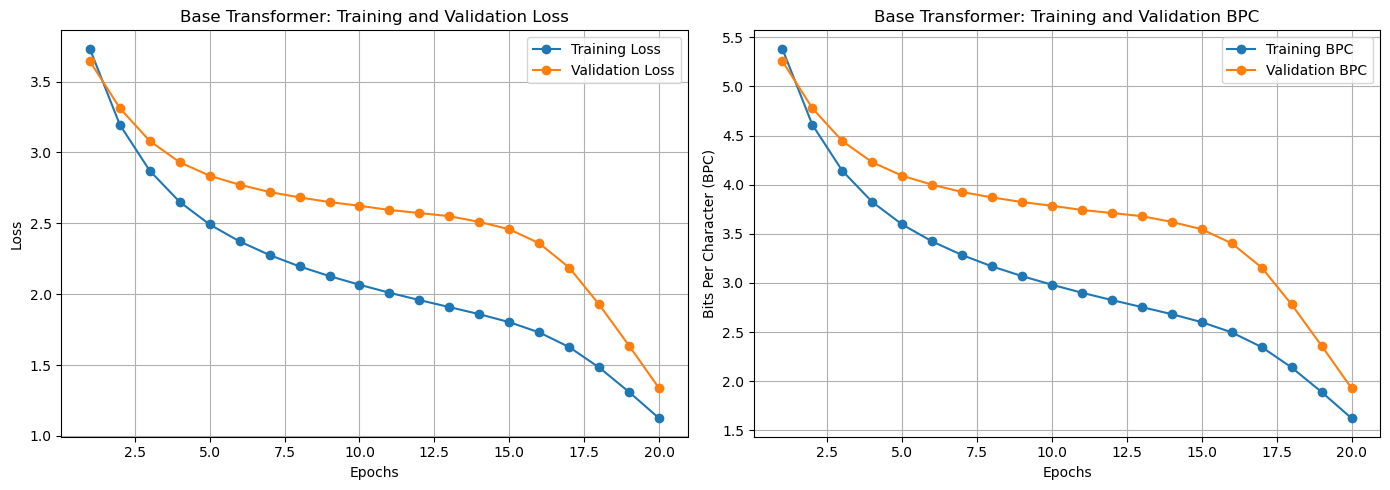

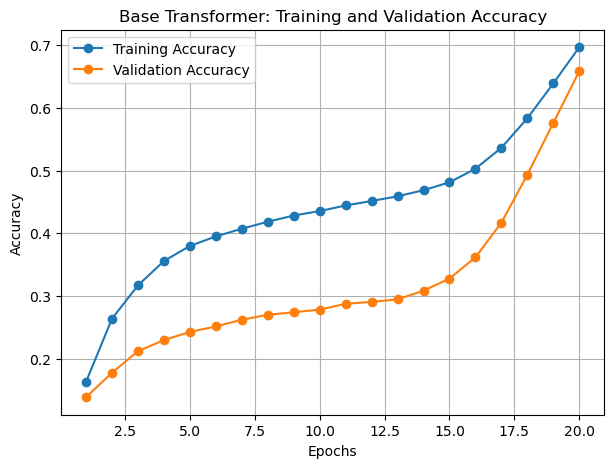

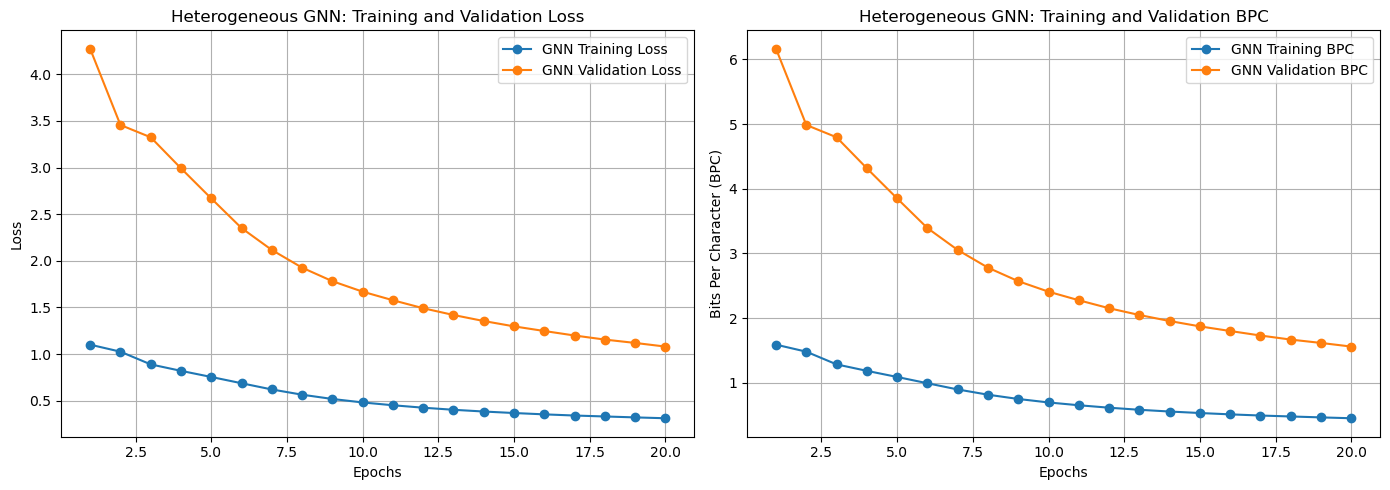

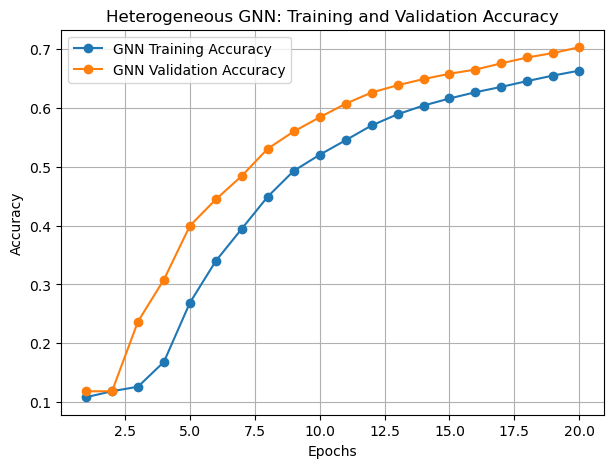

In [14]:
epochs_range = range(1, num_epochs + 1)

# Visualization of Training and Validation Loss and BPC for Base Transformer Model
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Base Transformer: Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot BPC
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_bpcs, label='Training BPC', marker='o')
plt.plot(epochs_range, val_bpcs, label='Validation BPC', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Bits Per Character (BPC)')
plt.title('Base Transformer: Training and Validation BPC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualization of Training and Validation Accuracy for Base Transformer Model
plt.figure(figsize=(7, 5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Base Transformer: Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Visualization of Training and Validation Loss and BPC for Heterogeneous GNN Model
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, gnn_train_losses, label='GNN Training Loss', marker='o')
plt.plot(epochs_range, gnn_val_losses, label='GNN Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Heterogeneous GNN: Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot BPC
plt.subplot(1, 2, 2)
plt.plot(epochs_range, gnn_train_bpcs, label='GNN Training BPC', marker='o')
plt.plot(epochs_range, gnn_val_bpcs, label='GNN Validation BPC', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Bits Per Character (BPC)')
plt.title('Heterogeneous GNN: Training and Validation BPC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualization of Training and Validation Accuracy for Heterogeneous GNN Model
plt.figure(figsize=(7, 5))
plt.plot(epochs_range, gnn_train_accuracies, label='GNN Training Accuracy', marker='o')
plt.plot(epochs_range, gnn_val_accuracies, label='GNN Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Heterogeneous GNN: Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()